**Загрузите датасет titanic из kaggle (https://www.kaggle.com/datasets/vinicius150987/titanic3) или с локального компьютера. (Data path на Kaggle = 'vinicius150987/titanic3', файл в формате Excel). Загрузите pandas dataframe, используя функцию pd.read_excel(). НЕполный датасет titanic есть также в seaborn.**

**Проверьте нуль-гипотезу о том, что средний возраст пассажиров (age) в группах с билетами разных классов (pclass) равен.
- Визуализируйте данные (зависимая переменная в трех группах).
- Постройте  таблицу ANOVA (используйте тип 2).
- Проверьте предположения.
- Проведите множественные сравнения, выбрав поправку.
- Интерпретируйте результаты статистически и содержательно.
- Не забудьте о кознях со стороны миссингов**

**Можно выбрать между библиотеками statsmodels и pingouin**

**Для тех, кому возраст пассажиров скучен: возьмите другой датафрейм из числа тех, что рассматривались в ноубуке s03a-Сравнение средних, напр., affairs, wcgs и др. Самостоятельно выберите интервальную зависимую переменную и фактор -- независимую переменную (рекомендуется с небольшим количеством уровней). Если клетки таблицы частот (pd.value_counts() ) для "фактора" окажутся пусты, придется объединить уровни (см основной ноутбук по этой теме или другие материалы). Все необходимые шаги остаются: визуализация, таблица ANOVA, предположения, множественные сравнения, интерпртетация, подстерегающие миссинги** 


In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.multicomp as mc
from scipy import stats
import missingno as msno
from statsmodels.imputation.mice import MICEData
from statsmodels.imputation import mice
from scipy.stats import kruskal

In [2]:
# Доступ к файлу удалось получить только предварительно скачав его на ПК
file = '/Users/Administrator/Documents/Finale Files/titanic3.xls'
df = pd.read_excel(file)

In [3]:
# Среди последних 20 пассажиров обнаружились миссинги в age в строках 1291,1292,1293,1297,1302,1303,1305
df1 = df[['pclass', 'age', 'sex', 'fare', 'embarked']]
df1.tail(20)

,pclass,age,sex,fare,embarked
1289,3,21.0,male,6.4958,S
1290,3,47.0,female,7.0000,S
1291,3,NaN,male,8.7125,S
1292,3,NaN,male,7.5500,S
1293,3,NaN,male,8.0500,S
1294,3,28.5,male,16.1000,S
1295,3,21.0,male,7.2500,S
1296,3,27.0,male,8.6625,S
1297,3,NaN,male,7.2500,S
1298,3,36.0,male,9.5000,S


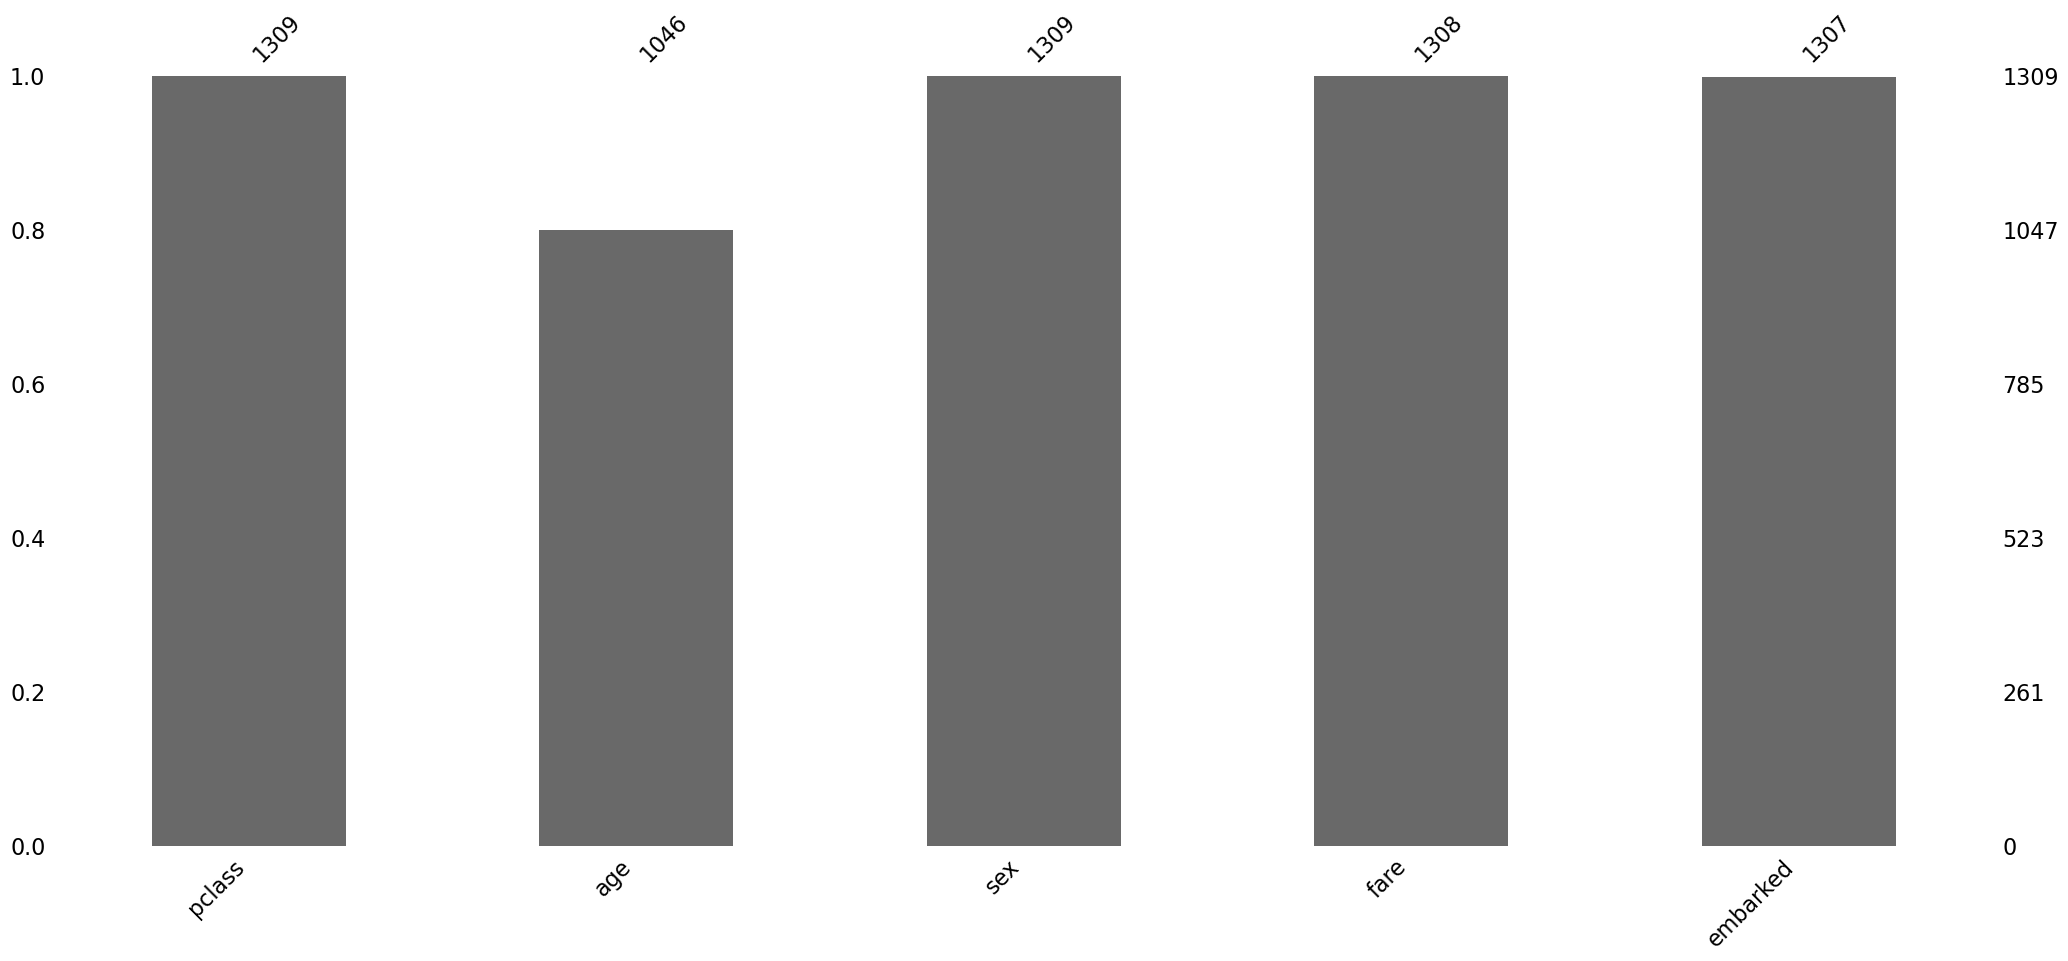

In [4]:
# Всего обнаружено 263 миссинга в age
msno.bar(df1);

In [5]:
# Проведем подстановку пропущенных значений для переменной age с использованием метода MICE
df1 = df1.copy()
df1['sex'] = df1['sex'].map({'male': 0, 'female': 1})
df1['embarked'] = df1['embarked'].map({'S': 0, 'Q': 1, 'C': 2})
imp = MICEData(df1)
imp.set_imputer('age', formula='C(sex) + C(embarked) + fare')
imp.update_all(n_iter=20)
filled_data = imp.data
df1.loc[:, 'age'] = filled_data['age']

In [6]:
df1.tail(20)

,pclass,age,sex,fare,embarked
1289,3,21.0,0,6.4958,0.0
1290,3,47.0,1,7.0000,0.0
1291,3,18.0,0,8.7125,0.0
1292,3,36.0,0,7.5500,0.0
1293,3,24.0,0,8.0500,0.0
1294,3,28.5,0,16.1000,0.0
1295,3,21.0,0,7.2500,0.0
1296,3,27.0,0,8.6625,0.0
1297,3,28.0,0,7.2500,0.0
1298,3,36.0,0,9.5000,0.0


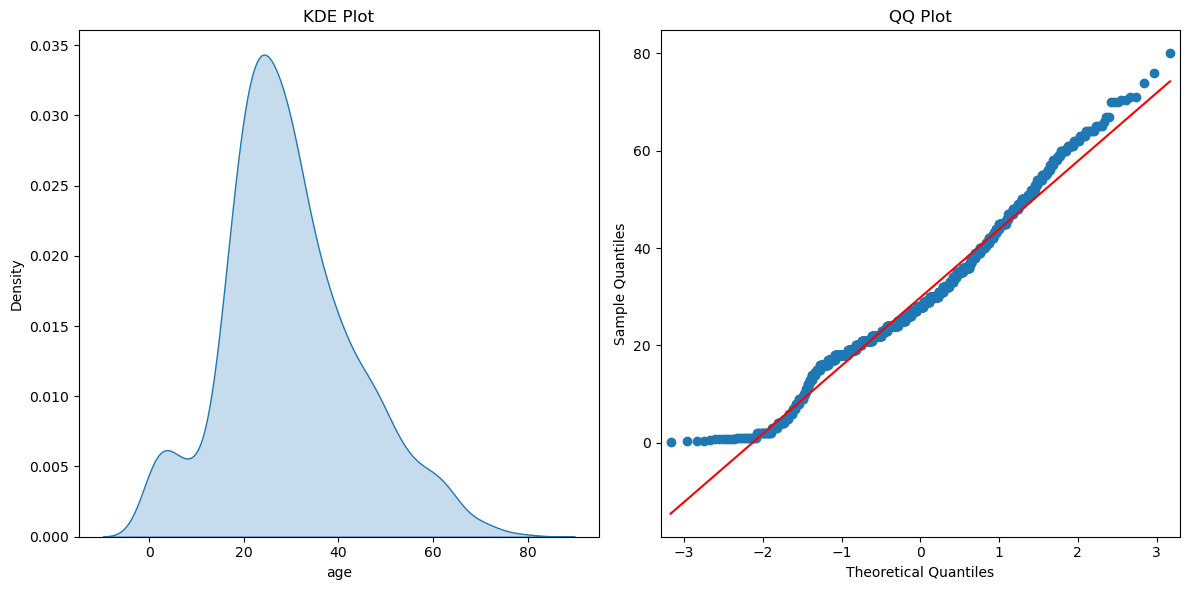

In [7]:
# Визуализация распределения возраста с использванием KDE Plot и QQ-Plot
# Наблюдается приблизительно нормальное распределение age по KDE Plot и QQ-Plot, т.е. можно использовать ANOVA как относительно робастный метод
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(df1['age'], fill=True)
plt.title('KDE Plot')
          
plt.subplot(1, 2, 2)
sm.qqplot(df1['age'], line='s', ax=plt.gca())
plt.title('QQ Plot')
plt.tight_layout();

In [8]:
# Вычисление количества пассажиров в каждом классе билетов
df1.pclass.value_counts()

pclass
3    709
1    323
2    277
Name: count, dtype: int64

In [9]:
# Проведение регрессионного анализа
mdl_age = smf.ols(formula = 'age ~ C(pclass)', data=df1).fit()
mdl_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     116.1
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           4.06e-47
Time:                        10:07:29   Log-Likelihood:                -5205.8
No. Observations:                1309   AIC:                         1.042e+04
Df Residuals:                    1306   BIC:                         1.043e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         38.9703      0.719     54.190      0.000      37.560      40.381
C(pclass)[T.2]    -9.2655      1.058     -8.754      0.000     -11.342      -7.189
C(pclass)[T.3]   -13.2169      0.868    -15.234      0.000     -14.919     -11.515
==============================================================================
Omnibus:                       26.808   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.085
Skew:                           0.299   Prob(JB):                     2.93e-07
Kurtosis:                       3.441   Cond. No.                         4.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

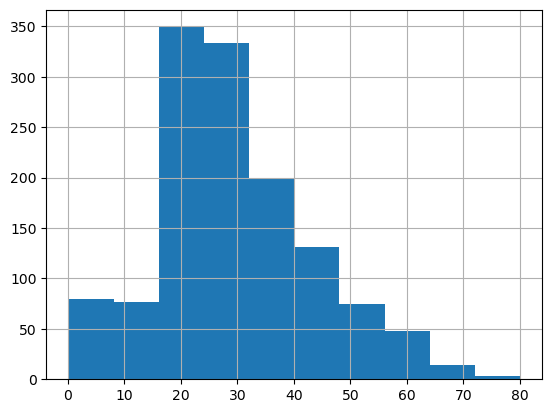

In [10]:
# Визуализация распределения возрастов пассажиров (как часто встречаются различные возрастные группы)
df1.age.hist();

In [11]:
mdl_age_log = smf.ols(formula = 'np.log(age) ~ C(pclass)', data=df1).fit()
mdl_age_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(age)   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     54.58
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           1.72e-23
Time:                        10:07:31   Log-Likelihood:                -1419.0
No. Observations:                1309   AIC:                             2844.
Df Residuals:                    1306   BIC:                             2860.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.5706      0.040     89.598      0.000       3.492       3.649
C(pclass)[T.2]    -0.3621      0.059     -6.174      0.000      -0.477      -0.247
C(pclass)[T.3]    -0.5020      0.048    -10.442      0.000      -0.596      -0.408
==============================================================================
Omnibus:                      794.920   Durbin-Watson:                   1.588
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7337.243
Skew:                          -2.751   Prob(JB):                         0.00
Kurtosis:                      13.210   Cond. No.                         4.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Выводы:
1. Коэффициент Jarque-Bera после логарифмирования переменной age увеличился = 7337.243 instead 30.085 - т.е. остатки модели не распределены нормально.

In [12]:
# Проводим дисперсионный анализ (ANOVA)
anova_table = sm.stats.anova_lm(mdl_age, typ=2)
print(anova_table)

                  sum_sq      df           F        PR(>F)
C(pclass)   38771.591750     2.0  116.052812  4.063796e-47
Residual   218158.000189  1306.0         NaN           NaN


Выводы:
1. При F-statistic = 116.05 и Prob (F-statistic) = 4.06e-47 - указывает что существуют значительные различия между группами с разными классами билетов.
2. Нуль-гипотеза о равенстве средних возрастов пассажиров в группах с разными классами билетов отвергается.

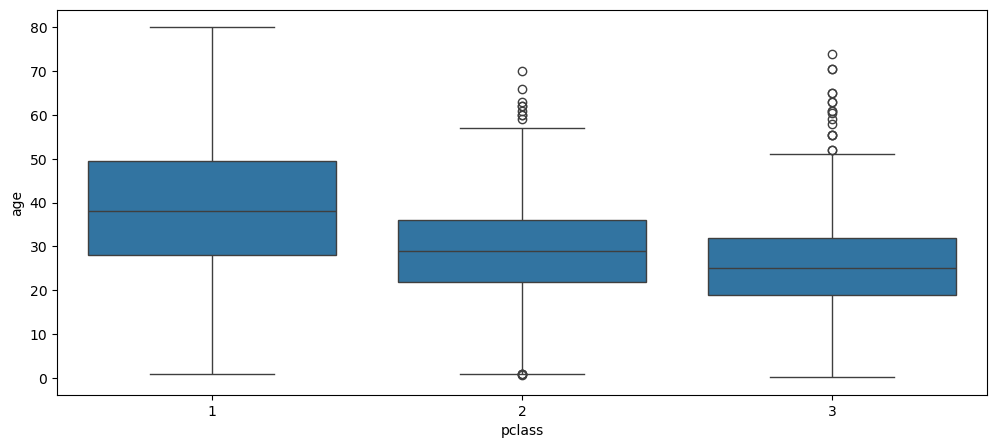

In [13]:
# Визуализация распределения возраста пассажиров по классам билетов
plt.figure(figsize=(12, 5))
sns.boxplot(x='pclass', y='age', data=df1);

In [15]:
# Гомоскедастичность нарушена: p-value = 2.998e-08 < 0.05
stat, p = stats.levene(df1[df1['pclass'] == 1]['age'], df1[df1['pclass'] == 2]['age'], df1[df1['pclass'] == 3]['age'])
print(f'Statistics={stat}, p-value={p}')

Statistics=17.554571625060465, p-value=2.9979332576829166e-08


In [16]:
# Проведем множественные сравнения с испльзованием пост-хок теста Холм
comp = mc.MultiComparison(df1['age'], df1['pclass'])
holm, a1, a2 = comp.allpairtest(sms.ttest_ind, method = "holm")
print(holm)

Test Multiple Comparison ttest_ind 
FWER=0.05 method=holm
alphacSidak=0.02, alphacBonf=0.017
group1 group2   stat  pval pval_corr reject
-------------------------------------------
     1      2  8.0425  0.0       0.0   True
     1      3 15.4007  0.0       0.0   True
     2      3  4.5225  0.0       0.0   True
-------------------------------------------


Вывод:
Между группами с билетами классов 1 и 2; 1 и 3; 2 и 3 существуют значимые различия в средних значениях возраста пассажиров.

In [17]:
# Проведем непараметрический тест Краскала-Уоллиса для сравнения независимых групп (pclass).
# p-value = 1.52e-40 < 0.05 - подтверждает вышеуказанный вывод
grouped_data = [df1[df1['pclass'] == i]['age'] for i in df1['pclass'].unique()]
statistic, p_value = kruskal(*grouped_data)
f'Statistic: {statistic}, p-value: {p_value}'

'Statistic: 183.36702550988835, p-value: 1.5217956173096198e-40'